In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [4]:
class Ant:
    def __init__(self, bounds=[-100, 100]):
        self.params = np.random.uniform(bounds[0], bounds[1], 2)
        self.fitness = None
    
    def update_params(self, params):
        self.params = params
    
    def update_fitness(self, fitness):
        self.fitness = fitness

    def get_params(self):
        return self.params

class Aco:
    def __init__(self, num_ants=10):
        self.num_ants = num_ants
        self.bounds = [-100, 100]
        self.ants = []
        self.best = None
        self.best_fitness = None
        self.iterations = []

    def ackley(self, x1, x2):
        return -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1 ** 2 + x2 ** 2))) - np.exp(
            0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2))) + np.e + 20
    
    def init_ants(self, num_ants):
        for i in range(num_ants):
            self.ants.append(Ant(bounds=self.bounds))
        
    def update_best(self):
        for ant in self.ants:
            if self.best_fitness is None or ant.fitness < self.best_fitness:
                self.best = ant
                self.best_fitness = ant.fitness

    def calculate_probabilities(self, ant, pheromone, alpha, beta):
        probabilities = []
        total = 0

        for i in range(len(ant.params)):
            numerator = (pheromone[i] ** alpha) * ((1.0 / ant.params[i]) ** beta)
            probabilities.append(numerator)
            total += numerator

        probabilities = [numerator / total for numerator in probabilities]
        return probabilities
    
    def update_pheromone_probabilistc(self, alpha, beta, rho):
        pheromone = [1.0] * len(self.best.params)

        for ant in self.ants:
            probabilities = self.calculate_probabilities(ant, pheromone, alpha, beta)
            selected_params = []

            for i in range(len(ant.params)):
                random_value = np.random.uniform(0, 1)
                cumulative_prob = 0

                for j in range(len(probabilities)):
                    cumulative_prob += probabilities[j]

                    if random_value <= cumulative_prob:
                        selected_params.append(self.best.params[j])
                        break

            selected_params = np.array(selected_params)
            ant.update_params((1 - rho) * ant.params + alpha * np.random.uniform(-1, 1) + beta * (selected_params - ant.params))

        pheromone = [(1 - rho) * pheromone[i] + self.best_fitness / ant.params[i] for i in range(len(self.best.params))]

    def update_pheromone(self, alpha, beta, rho):
        for ant in self.ants:
            for i in range(len(ant.params)):
                ant.params[i] = (1 - rho) * ant.params[i] + alpha * np.random.uniform(-1, 1) + beta * (self.best.params[i] - ant.params[i])

    def update_ants(self, num_iter=1000, alpha=1, beta=1, rho=0.5):
        for i in range(num_iter):
            for ant in self.ants:
                params = ant.params + np.random.uniform(-1, 1)
                fitness = self.ackley(params[0], params[1])
                ant.update_params(params)
                ant.update_fitness(fitness)
            self.update_best()
            #self.update_pheromone(alpha, beta, rho)
            self.update_pheromone_probabilistc(alpha, beta, rho)
            self.iterations.append(self.best_fitness)
    

    def plot_best_solution(self):
        search_space = np.linspace(100, -100, 100)
        X, Y = np.meshgrid(search_space, search_space)
        Z = self.ackley(X, Y)

        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.3)

        x_best, y_best = self.best.get_params()
        z_best = self.best_fitness

        ax.scatter(x_best, y_best, z_best, c='r', marker='o', s=100, label='Best Solution')
        ax.text(x_best, y_best, z_best, f'({x_best:.2f}, {y_best:.2f}, {z_best:.2f})', color='black', fontsize=10)

        ax.set_title('Best Solution')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Fitness')

        ax.autoscale(enable=True, tight=True)
        ax.view_init(elev=30, azim=-45)

        plt.legend()
        plt.show()

    def plot_iterations(self, smoothing_factor=0.1):
        smoothed_iterations = [self.iterations[0]]
        for i in range(1, len(self.iterations)):
            smoothed_value = smoothing_factor * self.iterations[i] + (1 - smoothing_factor) * smoothed_iterations[i-1]
            smoothed_iterations.append(smoothed_value)

        fig = plt.figure(figsize=(10, 8))
        plt.plot(smoothed_iterations, marker='o')
        plt.yscale('log')  # Usando escala logarítmica no eixo y
        plt.title('Smoothed Best Fitness per Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness (log scale)')  # Adicionando rótulo ao eixo y
        plt.grid(True)
        plt.show()

    def run(self, num_iter=1000, alpha=1, beta=1, rho=0.5):
        self.init_ants(self.num_ants)
        self.update_ants(num_iter, alpha, beta, rho)
        return self.best.params, self.best_fitness


In [5]:
aco = Aco(num_ants=10)
best_solution, best_fitness = aco.run(num_iter=10000)
print(f'Best solution: {best_solution}\nBest fitness: {best_fitness}')

Best solution: [-0.73838381 -0.73838381]
Best fitness: 3.609038833118916e-05


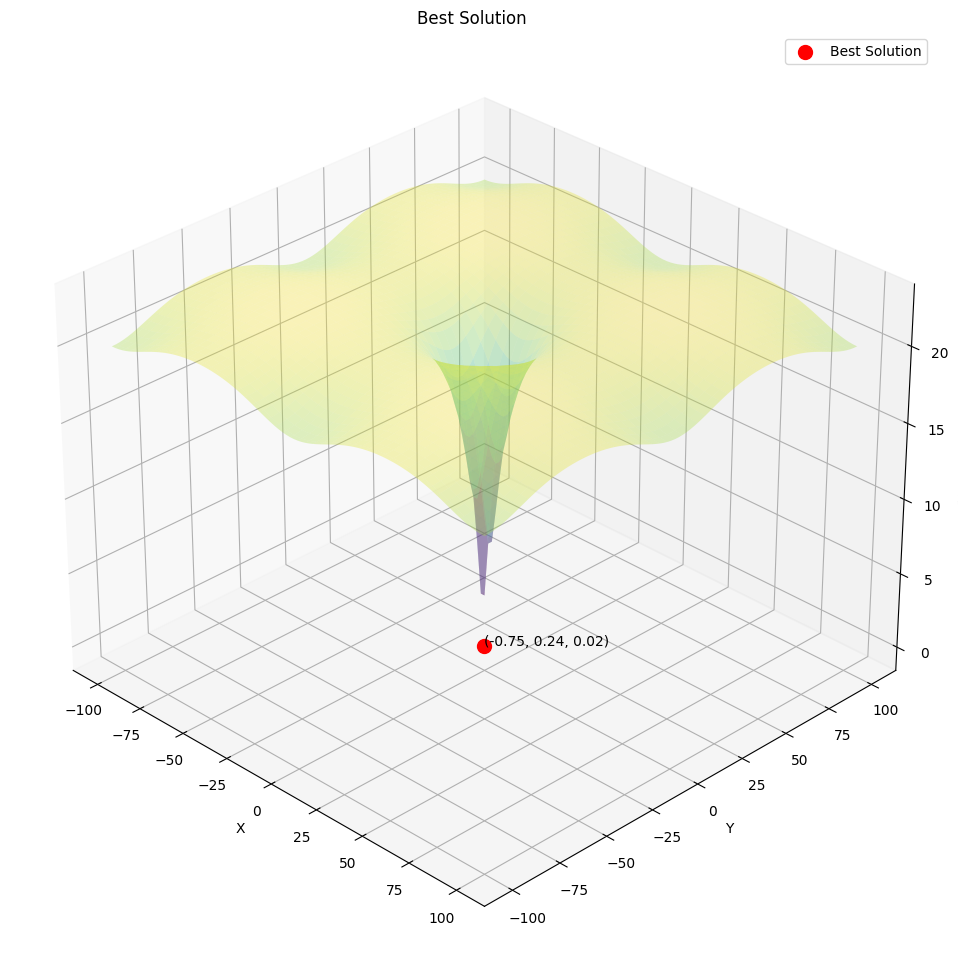

In [64]:
aco.plot_best_solution()

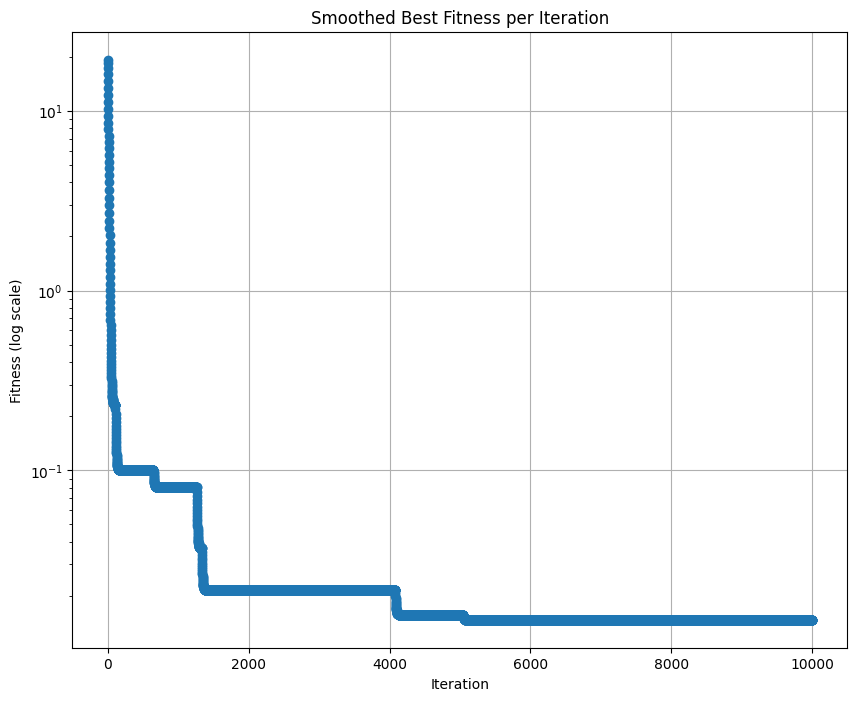

In [48]:
aco.plot_iterations()

In [57]:
tests = []

for num_ants in [10, 20, 50, 100]:
    for max_iterations in [1000, 5000, 10000]:
        for alpha in [0.5, 1, 2]:
            for beta in [0.5, 1, 2]:
                for rho in [0.1, 0.5, 0.9]:
                    aco = Aco(num_ants=num_ants)
                    best_solution, best_fitness = aco.run(num_iter=max_iterations, alpha=alpha, beta=beta, rho=rho)
                    tests.append({
                        'num_ants': num_ants,
                        'max_iterations': max_iterations,
                        'alpha': alpha,
                        'beta': beta,
                        'rho': rho,
                        'best_solution': best_solution,
                        'best_fitness': best_fitness
                    })


/tmp/ipykernel_56784/1466125501.py:25: RuntimeWarning: overflow encountered in scalar power
  return -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1 ** 2 + x2 ** 2))) - np.exp(
/tmp/ipykernel_56784/1466125501.py:25: RuntimeWarning: overflow encountered in scalar add
  return -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1 ** 2 + x2 ** 2))) - np.exp(
/tmp/ipykernel_56784/1466125501.py:26: RuntimeWarning: overflow encountered in scalar multiply
  0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2))) + np.e + 20
/tmp/ipykernel_56784/1466125501.py:26: RuntimeWarning: invalid value encountered in cos
  0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2))) + np.e + 20
/tmp/ipykernel_56784/1466125501.py:41: RuntimeWarning: overflow encountered in scalar multiply
  ant.params[i] = (1 - rho) * ant.params[i] + alpha * np.random.uniform(-1, 1) + beta * (self.best.params[i] - ant.params[i])
/tmp/ipykernel_56784/1466125501.py:41: RuntimeWarning: invalid value encountered in scalar add
  ant.params[i] = (1 - rho)

In [58]:
tests_df = pd.DataFrame(tests)

In [59]:
tests_df

,num_ants,max_iterations,alpha,beta,rho,best_solution,best_fitness
0,10,1000,0.5,0.5,0.1,"[1.2758086891378642, 0.27115741093507595]",0.058477
1,10,1000,0.5,0.5,0.5,"[-1.0288558850066067, -0.45790736595913506]",0.005189
2,10,1000,0.5,0.5,0.9,"[0.3179313048586283, -0.41901049391405193]",0.060536
3,10,1000,0.5,1.0,0.1,"[0.02963040430817565, 1.5946484822361828]",0.087449
4,10,1000,0.5,1.0,0.5,"[0.14843663209073432, -0.1048797966206832]",0.072774
...,...,...,...,...,...,...,...
319,100,10000,2.0,1.0,0.5,"[-0.5152410055853931, 2.185438290179939]",0.003827
320,100,10000,2.0,1.0,0.9,"[-1.9516588270945456, 0.575848022602932]",0.007325
321,100,10000,2.0,2.0,0.1,"[-1.6900097516502068, 1.1100540320584968]",0.186566
322,100,10000,2.0,2.0,0.5,"[-1.4405813663017022, -0.08880639055993411]",0.015894


In [60]:
tests_df.to_csv('aco_tests.csv', index=False)

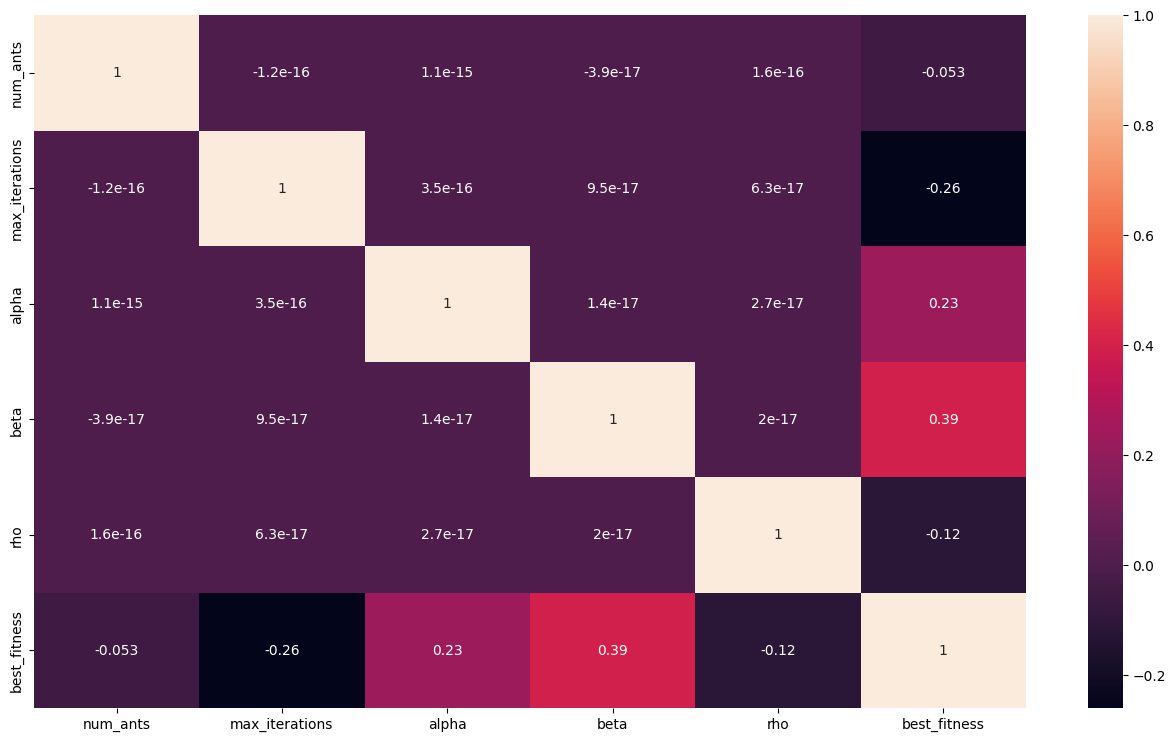

In [84]:
heatmap = tests_df.copy()
heatmap.drop(['best_solution'], axis=1, inplace=True)

fig = plt.figure(figsize=(16, 9))
sns.heatmap(heatmap.corr(), annot=True)
plt.show()

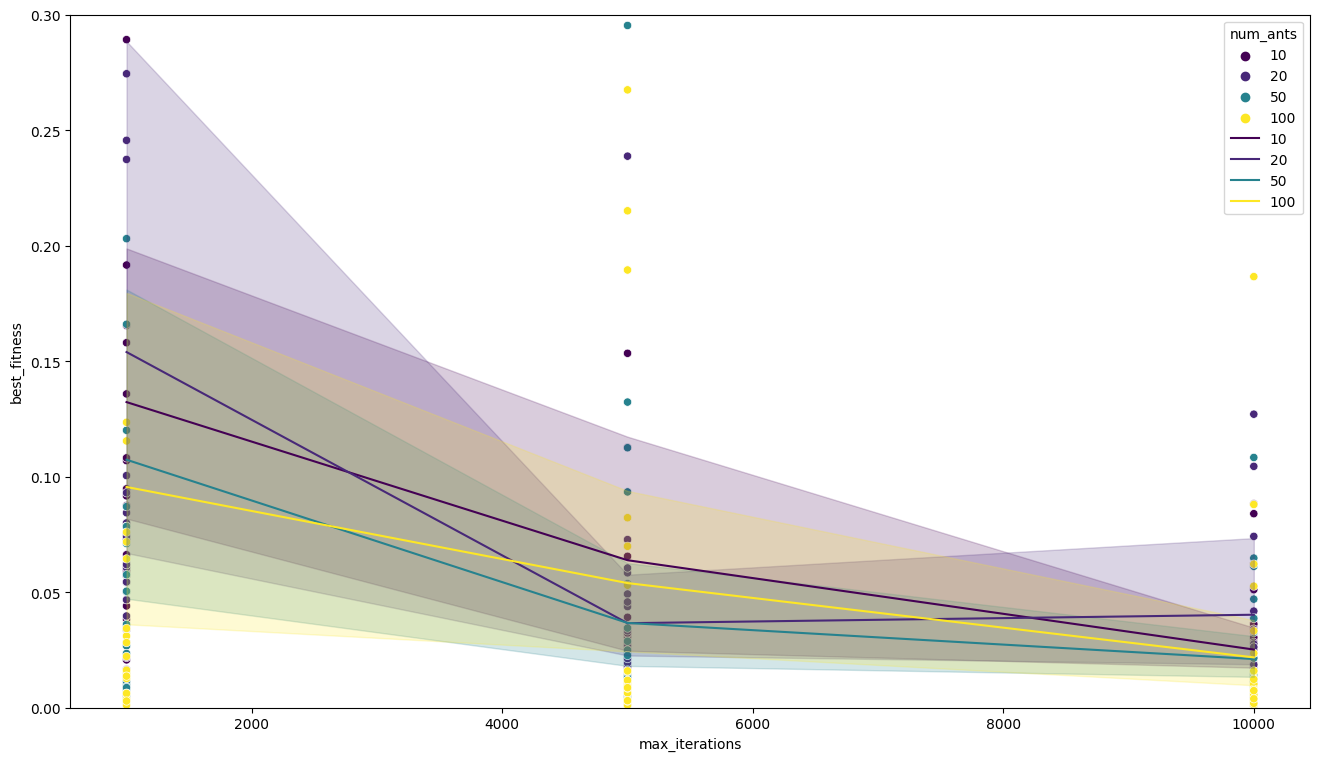

In [98]:
fig = plt.figure(figsize=(16, 9))
sns.scatterplot(data=tests_df, x='max_iterations', y='best_fitness', hue='num_ants', palette='viridis')
sns.lineplot(data=tests_df, x='max_iterations', y='best_fitness', hue='num_ants', palette='viridis')
plt.ylim(0, 0.3)
plt.show()

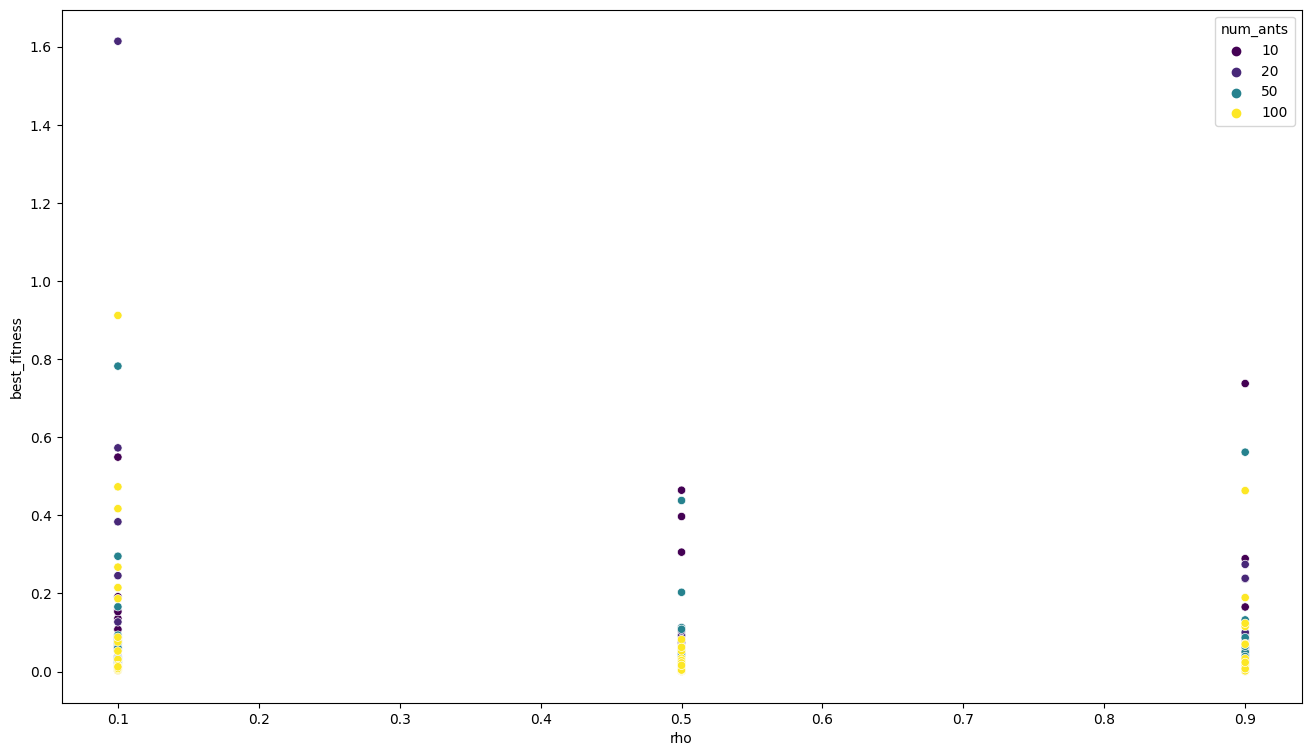

In [86]:
fig = plt.figure(figsize=(16, 9))
sns.scatterplot(data=tests_df, x='rho', y='best_fitness', hue='num_ants', palette='viridis')
plt.show()

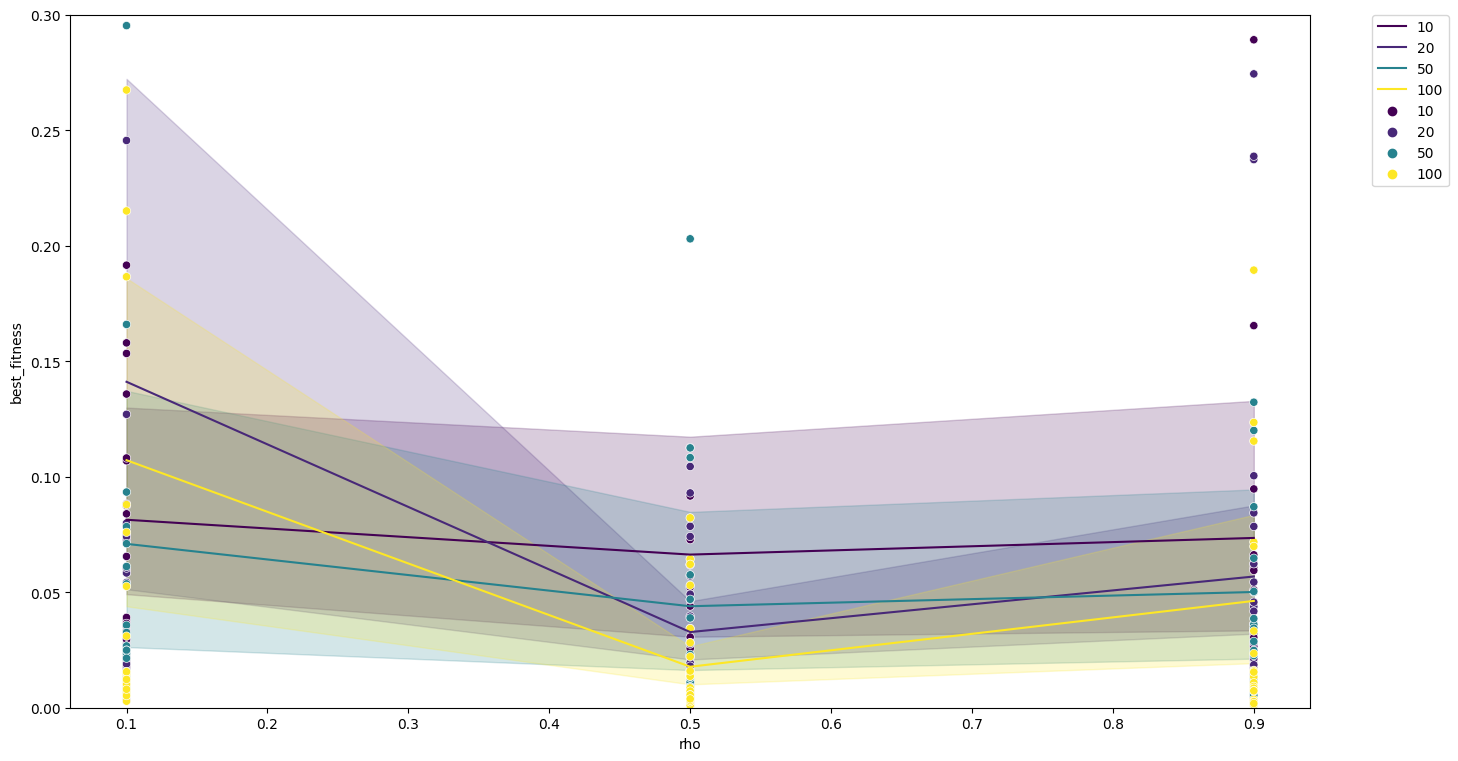

In [100]:
fig = plt.figure(figsize=(16, 9))
sns.lineplot(data=tests_df, x='rho', y='best_fitness', hue='num_ants', palette='viridis')
sns.scatterplot(data=tests_df, x='rho', y='best_fitness', hue='num_ants', palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0, 0.3)
plt.show()

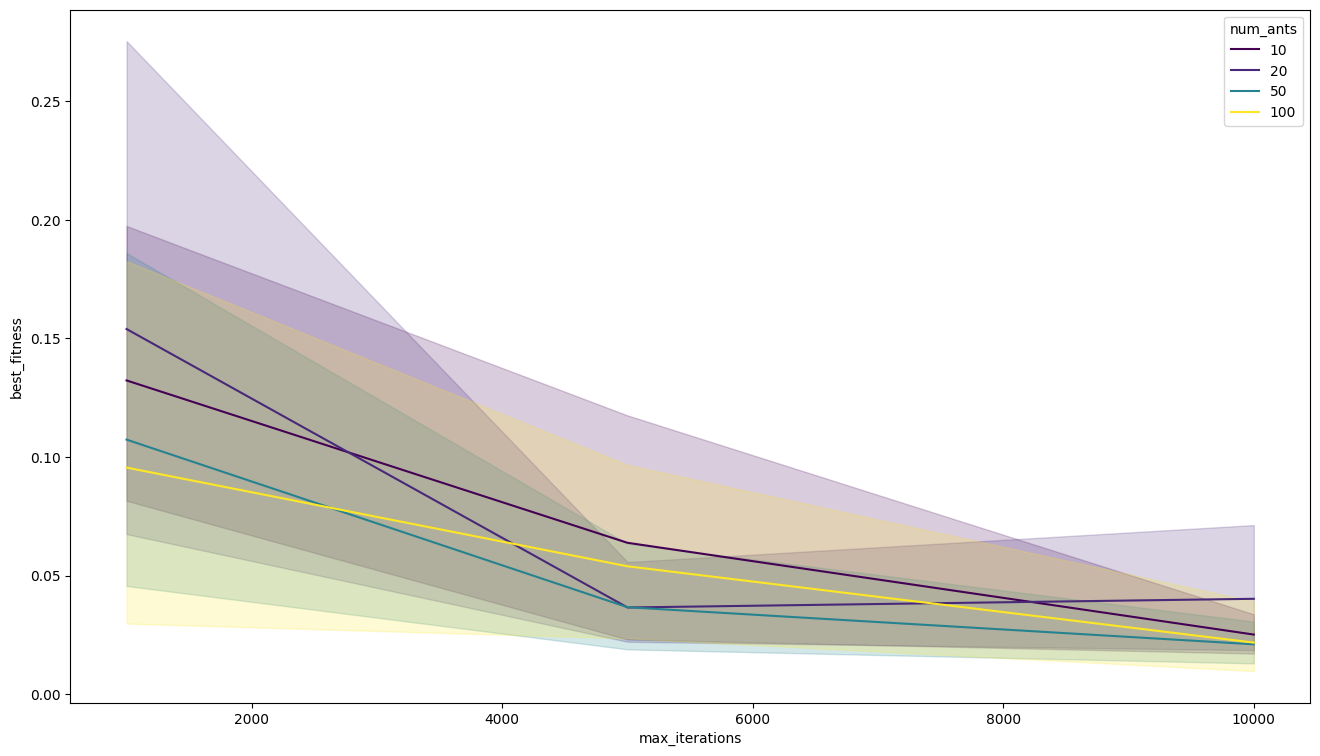

In [91]:
fig = plt.figure(figsize=(16, 9))
sns.lineplot(data=tests_df, x='max_iterations', y='best_fitness', hue='num_ants', palette='viridis')
plt.show()

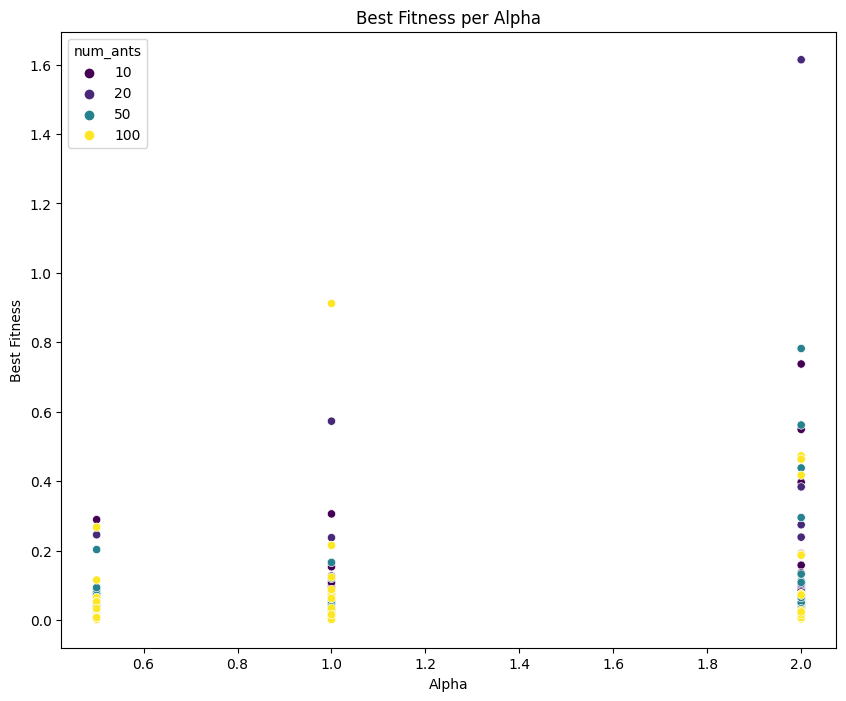

In [81]:
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(data=tests_df, x='alpha', y='best_fitness', hue='num_ants', palette='viridis')
plt.title('Best Fitness per Alpha')
plt.xlabel('Alpha')
plt.ylabel('Best Fitness')
plt.show()

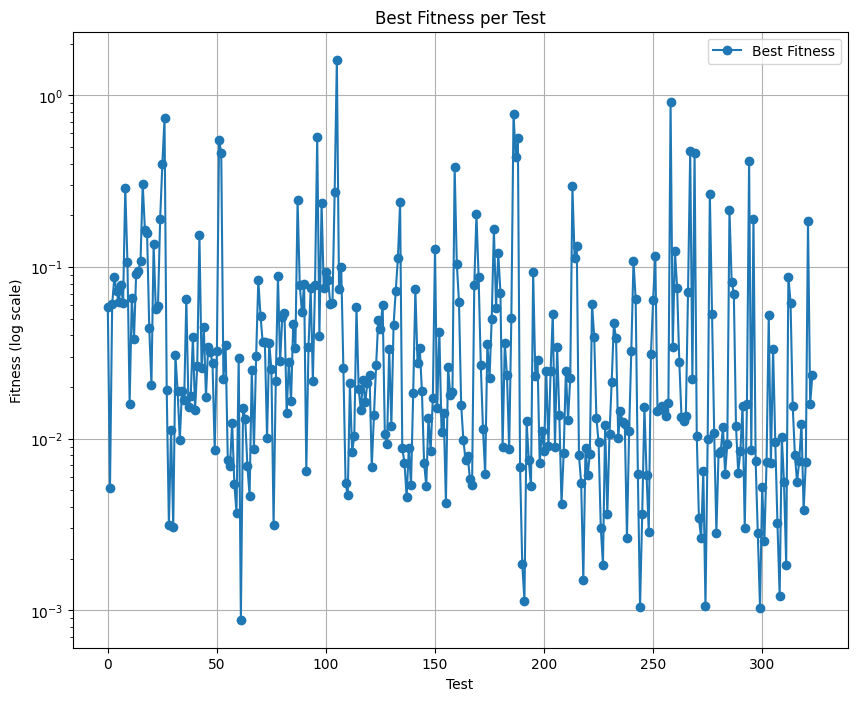

In [73]:
fig = plt.figure(figsize=(10, 8))
plt.plot(tests_df['best_fitness'], marker='o')
plt.yscale('log')  # Usando escala logarítmica no eixo y
plt.title('Best Fitness per Test')
plt.xlabel('Test')
plt.ylabel('Fitness (log scale)')  # Adicionando rótulo ao eixo y
plt.legend(['Best Fitness'])
plt.grid(True)
plt.show()

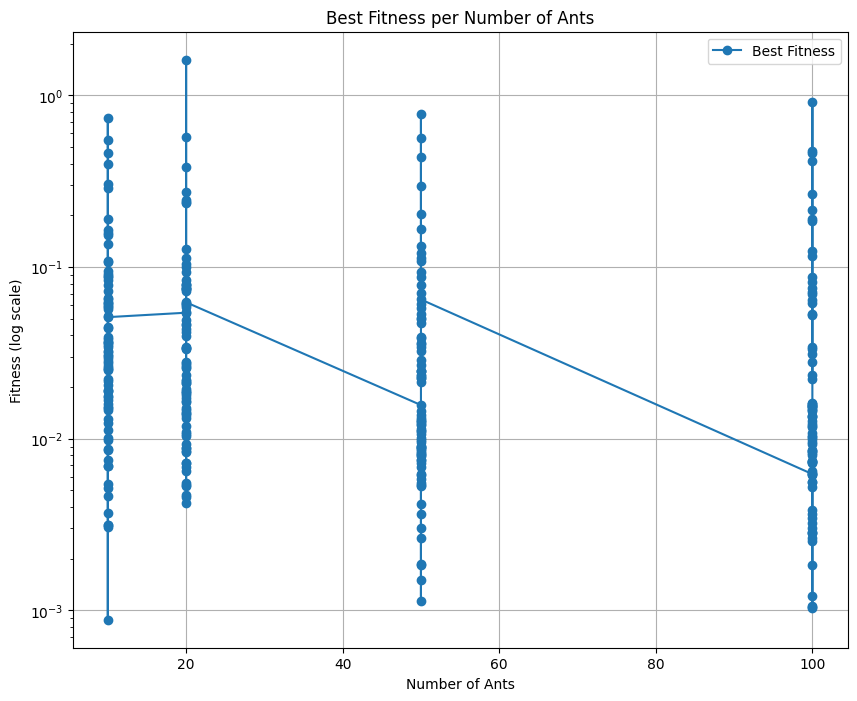

In [67]:
fig = plt.figure(figsize=(10, 8))
plt.plot(tests_df['num_ants'], tests_df['best_fitness'], marker='o')
plt.yscale('log')  # Usando escala logarítmica no eixo y
plt.title('Best Fitness per Number of Ants')
plt.xlabel('Number of Ants')
plt.ylabel('Fitness (log scale)')  # Adicionando rótulo ao eixo y
plt.legend(['Best Fitness'])
plt.grid(True)

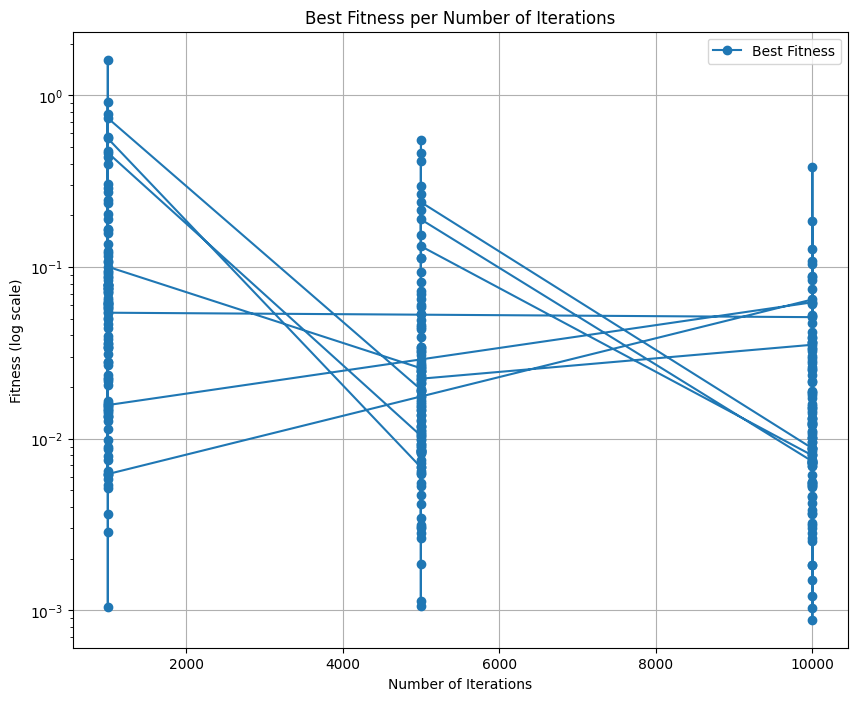

In [68]:
fig = plt.figure(figsize=(10, 8))
plt.plot(tests_df['max_iterations'], tests_df['best_fitness'], marker='o')
plt.yscale('log')  # Usando escala logarítmica no eixo y
plt.title('Best Fitness per Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness (log scale)')  # Adicionando rótulo ao eixo y
plt.legend(['Best Fitness'])
plt.grid(True)